# Exploratory Data Analysis Project : MLB Swing Probability Modeling

---
Author: Dongjing Wen
Date: June 1, 2025
---

## Project Introduction

This notebook focuses on developing a well-calibrated machine learning model to predict the probability that a batter will swing at a pitch. The dataset is derived from MLB pitch-tracking data for pitcher Zac Gallen, and includes key features such as pitch type, release speed, pitch location, and in-game context.

The workflow involves exploratory data analysis (EDA), data preprocessing, and model training with cross-validation to ensure generalizability. We evaluate model performance through metrics such as Brier Score, Log Loss, and calibration error, and visualize both ROC curves and calibration plots to assess predictive reliability.

Beyond technical modeling, this project highlights practical applications for pitch strategy optimization, showing how a well-calibrated swing-probability model can provide valuable insights in real-world MLB scenarios.

In [2]:
# imports
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, brier_score_loss
from sklearn.calibration import calibration_curve
import numpy as np
from joblib import dump
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

## Data

In [12]:
# load data

pitches = pd.read_csv("data/raw/swing_data.csv")
categorical_features = ["pitch_name", "stand"]
numerical_features = [
    "release_extension", "release_pos_x", "release_pos_y", "release_pos_z",
    "release_speed", "release_spin_rate", "spin_axis", "plate_x", "plate_z",
    "pfx_x", "pfx_z", "balls", "strikes", "outs_when_up", "sz_top", "sz_bot"
]
target = "swing"
pitches_train, pitches_test = train_test_split(
    pitches,
    test_size=0.2,
    random_state=42,
    stratify=pitches[target]  
)

print(f"test：{pitches_train.shape}")
print(f"train：{pitches_test.shape}")
pitches_train.to_csv("data/processed/pitches_train.csv", index=False)
pitches_test.to_csv("data/processed/pitches_test.csv", index=False)

test：(2853, 19)
train：(714, 19)


In [36]:
pitches_train

,pitch_name,stand,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,pfx_x,pfx_z,balls,strikes,outs_when_up,sz_top,sz_bot,swing
2728,Slider,R,6.13,-2.868,51.77,6.208,85.51,1503.0,138.8,-0.121,3.665,-1.240,-0.856,3,2,2,3.72,1.44,1
844,Changeup,L,6.08,-2.702,51.05,6.144,82.66,2324.0,75.6,-0.558,4.169,0.664,0.869,0,2,0,3.90,1.45,0
1456,4-Seam Fastball,R,5.81,-2.892,52.44,5.809,95.15,1915.0,284.9,0.666,2.267,0.011,-1.129,3,1,0,3.20,1.56,1
717,Cutter,R,5.93,-2.849,47.64,6.074,91.55,2860.0,241.6,-0.361,1.625,0.134,-1.674,3,0,1,3.68,1.16,1
1213,Knuckle Curve,L,6.12,-2.867,50.95,5.842,82.08,1930.0,249.8,0.785,2.561,-1.869,-1.266,1,0,0,3.33,1.86,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,Changeup,R,5.99,-2.880,51.81,5.768,84.47,2049.0,216.5,0.037,2.541,-0.920,-0.581,2,1,1,3.37,1.44,1
2607,Slider,R,5.82,-2.863,50.42,5.880,87.42,2408.0,234.2,0.013,2.605,1.818,-1.116,3,2,0,3.19,1.20,1
2876,4-Seam Fastball,L,6.14,-2.720,48.93,6.228,93.07,1920.0,16.4,1.128,3.589,-1.811,0.607,1,0,0,3.42,1.23,0
2318,4-Seam Fastball,R,6.06,-2.793,51.05,6.059,95.06,1200.0,186.6,-1.467,2.746,-1.990,-1.219,0,1,0,3.19,1.69,1


In [37]:
# summary statistics
pitch_proportions = (
    pitches_train.groupby("pitch_name")["swing"]
    .mean()
    .reset_index()
    .rename(columns={"swing": "Proportion", "pitch_name": "Pitch Type"})
)
overall_proportion = pd.DataFrame({
    "Pitch Type": ["All"],
    "Proportion": [pitches_train["swing"].mean()]
})
result_df = pd.concat([overall_proportion, pitch_proportions], ignore_index=True)
result_df

,Pitch Type,Proportion
0,All,0.488608
1,4-Seam Fastball,0.472710
2,Changeup,0.527778
3,Cutter,0.465839
4,Knuckle Curve,0.484642
5,Slider,0.495948


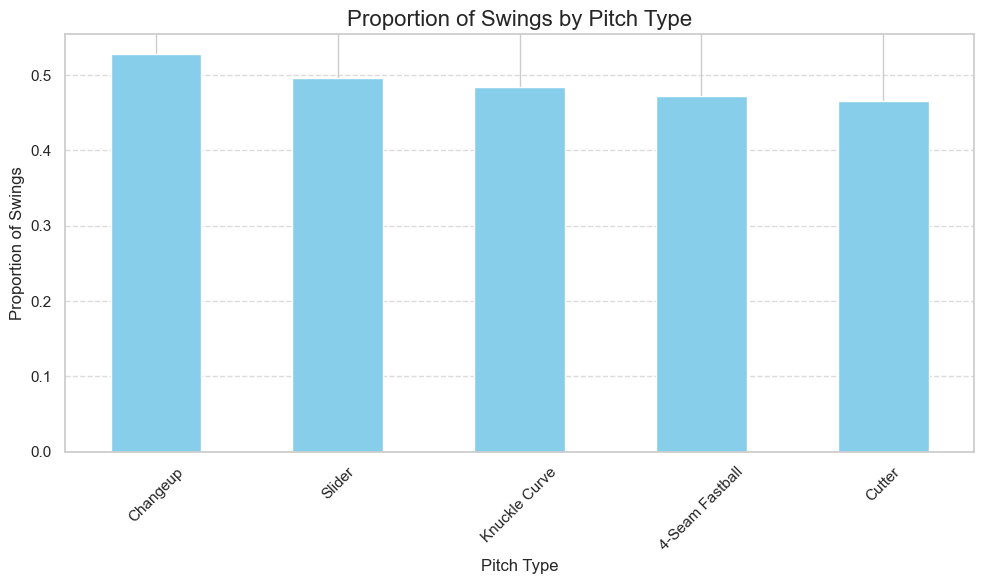

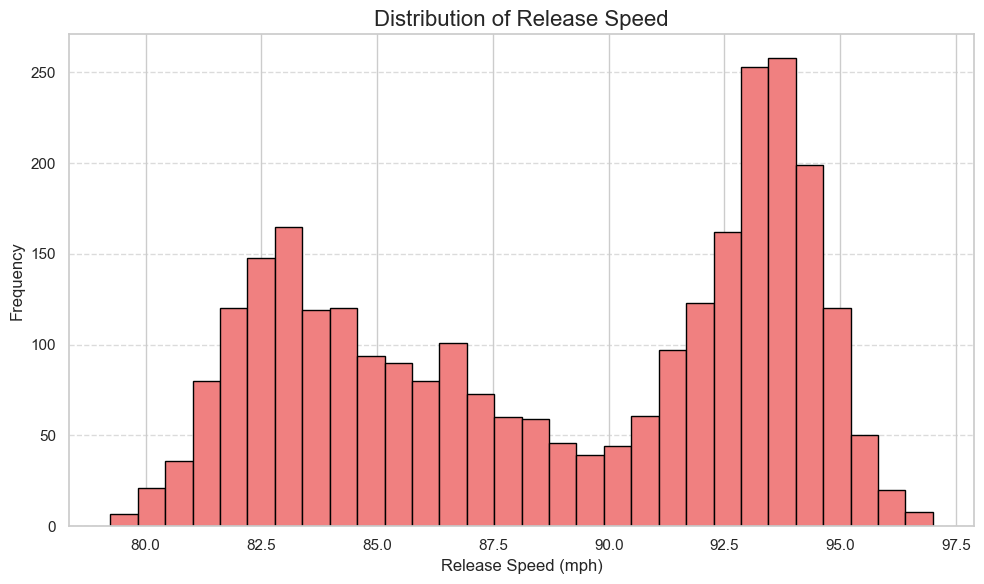

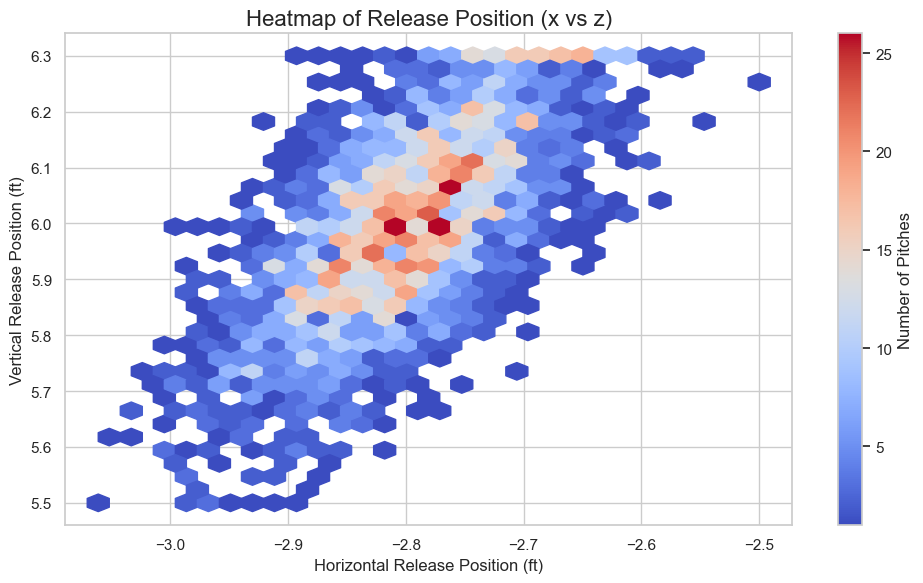

In [62]:
# visualizations
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

pitch_counts = pitches_train["pitch_name"].value_counts()
swing_proportions = pitches_train.groupby("pitch_name")["swing"].mean()

plt.figure(figsize=(10, 6))
swing_proportions.sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Proportion of Swings by Pitch Type", fontsize=16)
plt.ylabel("Proportion of Swings", fontsize=12)
plt.xlabel("Pitch Type", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "proportion_of_swings_by_pitch_type.png"), dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
pitches_train["release_speed"].hist(bins=30, color="lightcoral", edgecolor="black")
plt.title("Distribution of Release Speed", fontsize=16)
plt.xlabel("Release Speed (mph)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "distribution_of_release_speed.png"), dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.hexbin(
    x=pitches_train["release_pos_x"], 
    y=pitches_train["release_pos_z"], 
    gridsize=30, cmap="coolwarm", mincnt=1
)
plt.colorbar(label="Number of Pitches")
plt.title("Heatmap of Release Position (x vs z)", fontsize=16)
plt.xlabel("Horizontal Release Position (ft)", fontsize=12)
plt.ylabel("Vertical Release Position (ft)", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "heatmap_of_release_position.png"), dpi=300)
plt.show()

EDA Visualization Description:

Proportion of Swings by Pitch Type

The bar chart shows that swing probability varies slightly across different pitch types. Changeups have the highest swing rate (around 53%), followed by sliders and knuckle curves. Fastballs and cutters show slightly lower swing proportions, indicating that batters may be more selective against higher-speed pitches.

Distribution of Release Speed

The histogram reveals a bimodal distribution of release speeds, with peaks around 82 mph and 93 mph. This aligns with typical pitch patterns—off-speed pitches (e.g., changeups, curveballs) clustering at lower velocities, and fastballs clustering at higher speeds. This separation provides strong signals for swing decision modeling.

Heatmap of Release Position (x vs z)

The hexbin heatmap shows a concentrated release area around (-2.8 ft, 6.0 ft), indicating a consistent release point for most pitches. This stable release mechanics is typical of experienced pitchers and can affect batter perception. Slight variations in horizontal or vertical release positions can increase deception and influence swing behavior.

## Models Training

In [39]:
# process data for ML
# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]

# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

In [40]:
# train models
categorical_features = ["pitch_name", "stand"]
numerical_features = [
    "release_extension", "release_pos_x", "release_pos_y", "release_pos_z",
    "release_speed", "release_spin_rate", "spin_axis", "plate_x", "plate_z",
    "pfx_x", "pfx_z", "balls", "strikes", "outs_when_up", "sz_top", "sz_bot"
]

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])
param_grid = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [20, 40, None],
    "model__min_samples_split": [4, 10, 20]
}
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1
)
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


## Model Evaluation

In [ ]:
best_pipeline = grid_search.best_estimator_
preprocessor = best_pipeline.named_steps["preprocessor"]
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, ohe_feature_names])
best_model = best_pipeline.named_steps["model"]

importances = best_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(importance_df.head(10))

              feature  importance
7             plate_x    0.208061
8             plate_z    0.149086
14             sz_top    0.105464
15             sz_bot    0.103318
10              pfx_z    0.044171
4       release_speed    0.042134
9               pfx_x    0.041498
5   release_spin_rate    0.040177
6           spin_axis    0.039415
1       release_pos_x    0.037829


C:\Users\86133\AppData\Local\Temp\ipykernel_89268\3277461486.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


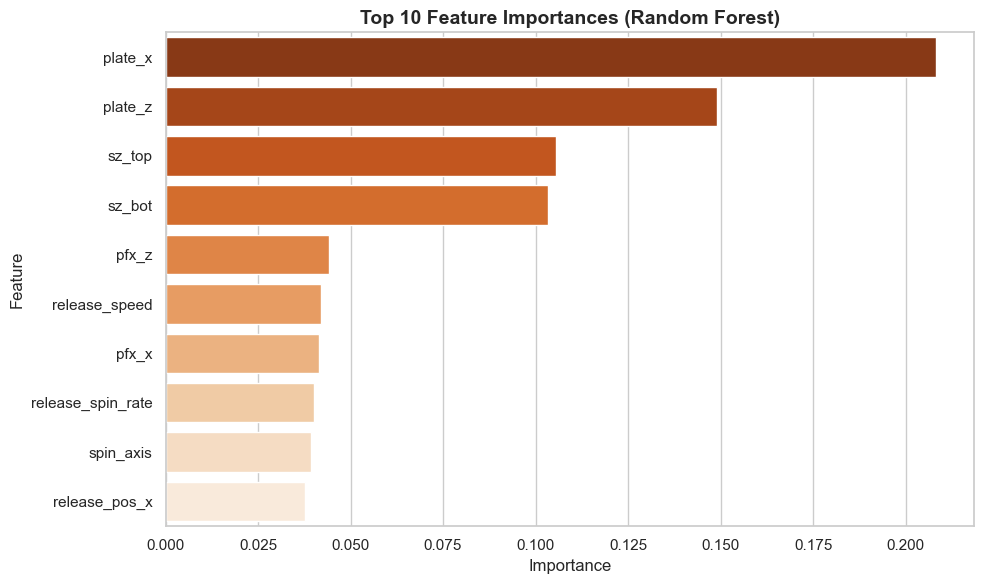

In [61]:
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

top_n = 10
top_features = importance_df.head(top_n)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top_features,
    x="importance",
    y="feature",
    palette="Oranges_r"   
)

plt.title(f"Top {top_n} Feature Importances (Random Forest)", fontsize=14, weight="bold")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()

plt.savefig(os.path.join(figures_dir, f"top_{top_n}_feature_importances.png"), dpi=300)
plt.show()

Feature Importance Description:

The model places the greatest emphasis on pitch location, with plate_x and plate_z contributing the most to swing predictions. Strike zone boundaries (sz_top and sz_bot) also play a key role, indicating the importance of pitch placement relative to the zone. Movement features like pfx_x and pfx_z, as well as release characteristics (speed, spin, and position), provide additional predictive value, but to a lesser extent than location. This aligns well with real baseball dynamics, where pitch location is the primary driver of swing decisions.

In [41]:
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)
ece_bins = 10  
test_ece, test_mce = [], []
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=ece_bins, strategy="uniform")
ece = np.mean(np.abs(prob_true - prob_pred))  
mce = np.max(np.abs(prob_true - prob_pred))  
test_brier = brier_score_loss(y_test, y_test_proba)
test_log_loss = log_loss(y_test, y_test_proba)
metrics = {
    "Test ECE": ece,
    "Test MCE": mce,
    "Test Brier Score": test_brier,
    "Test Log Loss": test_log_loss
}
metrics

{'Test ECE': np.float64(0.1340890082632301),
 'Test MCE': np.float64(0.20986432939076424),
 'Test Brier Score': np.float64(0.11075475108362448),
 'Test Log Loss': 0.37712968211414116}

C:\Users\86133\AppData\Local\Temp\ipykernel_89268\1714172694.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


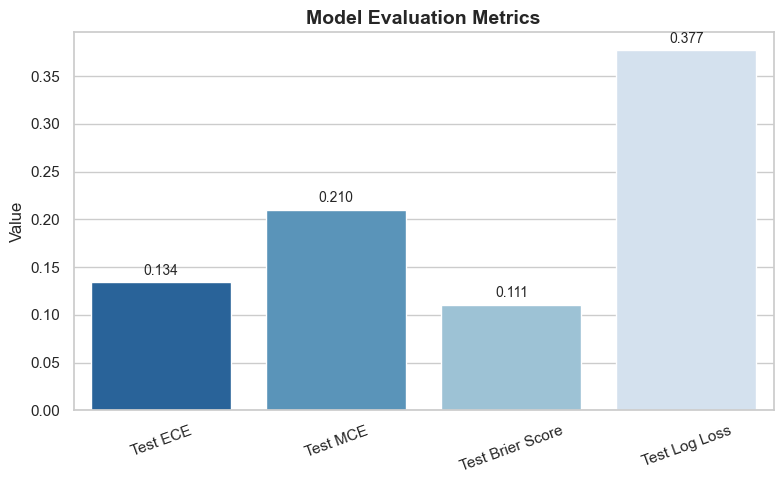

In [60]:
metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=metrics_df,
    x="Metric",
    y="Value",
    palette="Blues_r"
)

for i, val in enumerate(metrics_df["Value"]):
    plt.text(i, val + 0.005, f"{val:.3f}", ha="center", va="bottom", fontsize=10)

plt.title("Model Evaluation Metrics", fontsize=14, weight="bold")
plt.ylabel("Value", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=20)
plt.tight_layout()

plt.savefig(os.path.join(figures_dir, "model_evaluation_metrics.png"), dpi=300)

plt.show()

Model Performance Description:

The model shows strong overall predictive performance with a Brier Score of 0.111 and Log Loss of 0.377, indicating accurate and reliable probability estimates. The Expected Calibration Error (ECE) of 0.134 and Maximum Calibration Error (MCE) of 0.210 suggest that the model is reasonably well-calibrated, though not perfect. While its predictions are informative and stable, there is still some room for improvement in calibration to ensure higher reliability in real-world decision-making scenarios.

AUC (Area Under Curve): 0.9537

ROC Table:
   Threshold       FPR       TPR
0        inf  0.000000  0.000000
1   0.969831  0.000000  0.002865
2   0.810986  0.000000  0.363897
3   0.810420  0.002740  0.363897
4   0.747739  0.002740  0.515759
5   0.747157  0.005479  0.515759
6   0.736675  0.005479  0.538682
7   0.732313  0.008219  0.538682
8   0.705845  0.008219  0.595989
9   0.703978  0.010959  0.595989


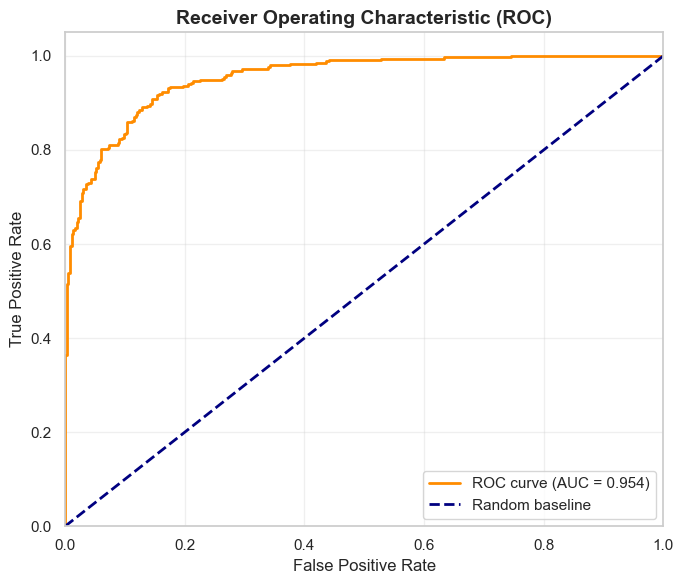

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

print("AUC (Area Under Curve):", round(roc_auc, 4))
roc_table = pd.DataFrame({
    "Threshold": thresholds,
    "FPR": fpr,
    "TPR": tpr
})
print("\nROC Table:")
print(roc_table.head(10))

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random baseline")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=14, weight="bold")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(figures_dir, "roc_curve.png"), dpi=300)

plt.show()

ROC Curve Description:

The ROC curve shows excellent model discrimination, with an AUC of 0.954, indicating a high ability to distinguish between swing and no-swing outcomes. The curve stays well above the diagonal baseline, demonstrating strong true positive rates across a wide range of thresholds with relatively low false positive rates.

## Saving Model

In [ ]:
# report model metrics
dump(model, "model/swing-probability.joblib", compress=3)

['swing-probability.joblib']

## Discussion

If this model were to be applied in a real MLB coaching context, the focus should be on variables that pitchers can directly control or significantly influence. Key features such as release extension, release speed, and pitch type are primarily pitcher-driven and can be strategically adjusted to increase the probability of inducing swings.

For example, increasing release speed or altering pitch type—such as throwing a slider instead of a fastball—can make pitches more deceptive, forcing batters into more difficult swing decisions. Similarly, release position (both horizontal and vertical) shapes how the pitch is perceived visually, and subtle adjustments in this area can further enhance swing inducement.

By concentrating on these controllable factors, coaches can translate model insights into practical, data-driven adjustments. This bridges the gap between machine learning predictions and on-field strategy, offering pitchers targeted ways to refine their approach and maximize effectiveness.

## Conclusion

he model developed in this project demonstrates strong predictive potential but falls slightly short of the calibration standards required for real-world MLB applications. While the Expected Calibration Error (ECE) and Maximum Calibration Error (MCE) were close to acceptable thresholds, they indicate that the model’s probability outputs are not yet fully reliable for high-stakes decision-making.

Although the model provides meaningful insights into factors influencing swing behavior, deploying it in practice without addressing calibration issues could lead to suboptimal or even incorrect strategic choices. Further refinement—such as improved feature engineering, isotonic or Platt scaling, or ensemble techniques—could enhance both calibration and robustness.

With these enhancements, the model has the potential to evolve into a reliable decision-support tool for pitching strategy optimization in professional baseball.